In [1]:
import HelperFunctions
import HDF5_Helpers
import pandas as pd
import numpy as np
import logging
import matplotlib.pyplot as plt

from GenericSearch import Process_Data
from StarData import get_vsini
from collections import defaultdict
import os

logger = logging.getLogger()
logger.setLevel(logging.INFO)
%matplotlib inline

Module 'anfft' (FFTW Python bindings) could not be imported.
To install it, try running 'easy_install anfft' from the terminal.
Falling back on the slower 'fftpack' module for ND Fourier transforms.


/home/kgullikson/anaconda3/envs/python2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [79]:
sample = HelperFunctions.read_observed_targets()
sample.Temperature = pd.to_numeric(sample.Temperature, errors='coerce')
detections = sample.loc[(sample.Temperature.notnull()) & (sample.Temperature < 9000)].copy()


In [80]:
# Set the addmode to use for everything to simple, except for one star where we need to use ml to detect...
detections['addmode'] = 'simple'
detections.loc[detections.identifier == 'HIP 18396', 'addmode'] = 'ml'

In [81]:
detections[['identifier', 'SpT', 'configuration', 'Instrument', 'Date', 'Temperature', '[Fe/H]', 'vsini_sec']].head(15)

,identifier,SpT,configuration,Instrument,Date,Temperature,[Fe/H],vsini_sec
10,HIP 2548,B9.5V,"(5.70(5.84B9.5V + 7.99; 25.55y e=.80) + 9.61; 27.5"")",HRS,20130812,5600,-0.5,30
11,HIP 2548,B9.5V,"(5.70(5.84B9.5V + 7.99; 25.55y e=.80) + 9.61; 27.5"")",IGRINS,20150806,6000,0.0,30
17,HIP 3478,B5V,B5V,TS23,20140112,5800,-0.5,5
30,HIP 5310,A3V,(A3V + ?; ?),IGRINS,20141014,3400,0.0,30
43,HR 545,B9.5IV,B9V,IGRINS,20141014,4500,-0.5,5
44,HR 545,B9.5IV,B9V,TS23,20131021,4500,-0.5,5
45,HR 545,B9.5IV,B9V,TS23,20140111,4500,0.0,5
48,HR 604,B8V+A0V,"(2.33K3IIb + 5.02(5.5(B7V + B9V; 2.67d) + 6.2A0V; 63.67y e=.93); 9.580"")",TS23,20131020,5000,0.5,5
51,HIP 10732,A1Vn,A1Vn,IGRINS,20141014,5500,0.0,5
52,HIP 10732,A1Vn,A1Vn,IGRINS,20150301,5700,0.0,10


In [145]:
detections.loc[detections.identifier == 'HIP 52678', ['Date', 'Temperature', 'vsini_sec', '[Fe/H]']]


,Date,Temperature,vsini_sec,[Fe/H]
273,20140201,5300,10,-0.5
274,20140331,5100,10,-0.5


In [5]:

import Analyze_CCF
reload(Analyze_CCF)
reload(HDF5_Helpers)
interface = HDF5_Helpers.Full_CCF_Interface(cache=True, update_cache=False, 
                                            cache_fname='/home/kgullikson/.PythonModules/CCF_metadata.csv')

INFO:root:Reading pre-made cache from /home/kgullikson/.PythonModules/CCF_metadata.csv


In [142]:
pd.set_option('max_colwidth',400)
starname, date, inst, addmode = 'HIP 52678', '2014-03-31', 'CHIRON', 'simple'
interface.get_measured_temperature(starname=starname, date=date, instrument=inst, 
                                   Tmax=5100, addmode=addmode, feh=-0.5, vsini=10)

INFO:root:HIP 52678, 2014-04-01, CHIRON, simple


,Tmeas,Tmeas_err,[Fe/H],logg,rv,significance,vsini,Star,Date,Instrument,addmode
0,5100.013592,216.015676,-0.5,4.5,18,8.139012,10,HIP 52678,2014-04-01,CHIRON,simple


# Get the measured temperature for every star

In [146]:
# Change instrument 'HRS' to 'HET'
detections.loc[detections.Instrument == 'HRS', 'Instrument'] = 'HET'

# Make a date string suitable for the HDF5 interface code
detections['parsed_date'] = detections.Date.astype(str).map(lambda s: '{}-{}-{}'.format(s[:4], s[4:6], s[6:8]))

# Get the updated information for each row
def get_tmeas(row):
    data = interface.get_measured_temperature(starname=row['identifier'],
                                              date=row['parsed_date'],
                                              instrument=row['Instrument'],
                                              Tmax=row['Temperature'],
                                              addmode=row['addmode'],
                                              feh=row['[Fe/H]'],
                                              vsini=row['vsini_sec'])
    Tmeas, Tmeas_err, sig = data.Tmeas.item(), data.Tmeas_err.item(), data.significance.item()
    #print(Tmeas, Tmeas_err, sig)
    return Tmeas, Tmeas_err, sig
out = detections.apply(get_tmeas, axis=1)

detections['Tmeas'], detections['Tmeas_err'], detections['significance'] = zip(*out)
detections[['identifier', 'SpT', 'configuration', 'Instrument', 'Date', 'Temperature', '[Fe/H]', 'vsini_sec', 'Tmeas', 'Tmeas_err', 'significance']].head()

INFO:root:HIP 2548, 2013-08-12, HET, simple
INFO:root:HIP 2548, 2015-08-06, IGRINS, simple
INFO:root:HIP 3478, 2014-01-12, TS23, simple
INFO:root:HIP 5310, 2014-10-15, IGRINS, simple
INFO:root:HR 545, 2014-10-15, IGRINS, simple
INFO:root:HR 545, 2013-10-21, TS23, simple
INFO:root:HR 545, 2014-01-11, TS23, simple
INFO:root:HR 604, 2013-10-20, TS23, simple
INFO:root:HIP 10732, 2014-10-15, IGRINS, simple
INFO:root:HIP 10732, 2015-03-02, IGRINS, simple
INFO:root:HIP 12332, 2014-10-17, IGRINS, simple
INFO:root:HIP 12332, 2014-01-20, TS23, simple
INFO:root:HIP 12706, 2014-10-16, IGRINS, simple
INFO:root:HIP 12706, 2013-10-19, TS23, simple
INFO:root:HIP 13165, 2013-08-14, HET, simple
INFO:root:HIP 13327, 2014-01-13, TS23, simple
INFO:root:HIP 14576, 2013-10-17, TS23, simple
/home/kgullikson/.PythonModules/GeneralScripts/HDF5_Helpers.py:428: UserWarning: No matches for T = 7100.0 with star/date = HIP 14576/2013-10-17!
  warnings.warn('No matches for T = {} with star/date = {}/{}!'.format(T, st

,identifier,SpT,configuration,Instrument,Date,Temperature,[Fe/H],vsini_sec,Tmeas,Tmeas_err,significance
10,HIP 2548,B9.5V,"(5.70(5.84B9.5V + 7.99; 25.55y e=.80) + 9.61; 27.5"")",HET,20130812,5600,-0.5,30,5600.047668,215.998031,29.055830
11,HIP 2548,B9.5V,"(5.70(5.84B9.5V + 7.99; 25.55y e=.80) + 9.61; 27.5"")",IGRINS,20150806,6000,0.0,30,6000.008180,216.001275,8.796868
17,HIP 3478,B5V,B5V,TS23,20140112,5800,-0.5,5,5799.802745,215.990025,31.099362
30,HIP 5310,A3V,(A3V + ?; ?),IGRINS,20141014,3400,0.0,30,3399.871770,215.846391,13.244871
43,HR 545,B9.5IV,B9V,IGRINS,20141014,4500,-0.5,5,4499.706320,215.693513,36.996533


In [150]:
cols = [u'identifier', u'SpT', u'configuration', u'Instrument', u'Date', u'Temperature',
        u'Velocity', u'vsini_sec', u'[Fe/H]', u'significance', 
        u'Comments', u'Rank', u'Keck', u'VLT', u'Gemini', 
        u'Imaging_Detecton', u'addmode', u'parsed_date', u'Tmeas', u'Tmeas_err']
detections[cols].to_csv('/home/kgullikson/School/Research/BinaryInference/Companion_Data.csv', 
                        encoding='utf-8', sep='|')

In [3]:
import datetime
t = datetime.datetime(2014, 3, 31) + datetime.timedelta(-1)
t.year, t.month, t.day

(2014, 3, 30)

In [2]:
df = pd.read_csv('/home/kgullikson/School/Research/BinaryInference/Companion_Data.csv', sep='|', index_col=0)
df.head()

,identifier,SpT,configuration,Instrument,Date,Temperature,Velocity,vsini_sec,[Fe/H],significance,Comments,Rank,Keck,VLT,Gemini,Imaging_Detecton,addmode,parsed_date,Tmeas,Tmeas_err
10,HIP 2548,B9.5V,(5.70(5.84B9.5V + 7.99; 25.55y e=.80) + 9.6...,HET,20130812,5600,6.985,30,-0.5,29.055830,Confirmed,1,n,Y,n,NaN,simple,2013-08-12,5600.047668,215.998031
11,HIP 2548,B9.5V,(5.70(5.84B9.5V + 7.99; 25.55y e=.80) + 9.6...,IGRINS,20150806,6000,2.853,30,0.0,8.796868,"Confirmed. Not detected with addmode=ml, and o...",1,n,Y,n,NaN,simple,2015-08-06,6000.008180,216.001275
17,HIP 3478,B5V,B5V,TS23,20140112,5800,-46.170,5,-0.5,31.099362,Very nice looking peak. Tens of sigma. This ex...,7,n,n,n,NaN,simple,2014-01-12,5799.802745,215.990025
30,HIP 5310,A3V,(A3V + ?; ?),IGRINS,20141014,3400,4.825,30,0.0,13.244871,Needs follow-up,3,Y,n,Y,NaN,simple,2014-10-14,3399.871770,215.846391
43,HR 545,B9.5IV,B9V,IGRINS,20141014,4500,-34.854,5,-0.5,36.996533,Confirmed,1,Y,n,n,NaN,simple,2014-10-14,4499.706320,215.693513


In [7]:
df.rename(columns=dict(identifier='Star'), inplace=True)
corrected = interface.convert_measured_to_actual(df)

$T = 5273.05281636^{+154.342372302}_{-154.320367543}$
$T = 5273.05281636^{+154.342372302}_{-154.320367543}$
$T = 5374.6612802^{+154.388542296}_{-154.363526365}$
$T = 5070.08856193^{+154.285134517}_{-154.269539667}$
$T = 4512.16947681^{+158.05047454}_{-158.055084308}$
$T = 4664.24017494^{+154.127762873}_{-154.126121229}$
$T = 4664.27544277^{+154.063060822}_{-154.061418226}$
$T = 5476.31844608^{+154.396482239}_{-154.368610328}$
$T = 5679.57278965^{+154.432533905}_{-154.399478567}$
$T = 5866.36362667^{+158.214009051}_{-158.199537582}$
$T = 5554.39752274^{+158.188733522}_{-158.178768532}$
$T = 4561.90881735^{+154.137560354}_{-154.139580042}$
$T = 4341.32685975^{+149.623501817}_{-149.629473115}$
$T = 4341.08294202^{+149.596442604}_{-149.602415274}$
$T = 5032.49526666^{+158.165677575}_{-158.163071221}$
$T = 4720.61588762^{+158.138836101}_{-158.140561711}$
$T = 5069.91973159^{+154.374869561}_{-154.359277635}$
$T = 5578.15337458^{+154.423340575}_{-154.392777463}$
$T = 5524.56258301^{+149.73792

In [8]:
corrected.head()

,,Corrected_Temperature,Star,T_lowerr,T_uperr
Star,,,,,
HIP 100221,0,5273.052816,HIP 100221,154.320368,154.342372
HIP 100907,0,5222.296969,HIP 100907,109.117903,109.128162
HIP 103298,0,4615.261736,HIP 103298,89.707201,89.706684
HIP 10732,0,5577.927970,HIP 10732,109.167502,109.182909
HIP 109139,0,5710.369509,HIP 109139,111.857153,111.863261


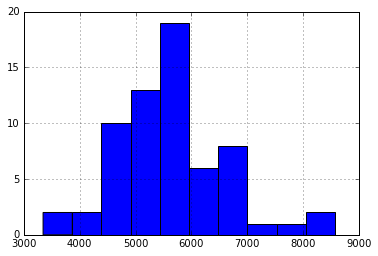

In [11]:
corrected.Corrected_Temperature.hist()

In [12]:
from Distributions import teff2mass

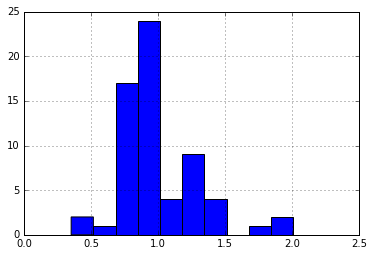

In [13]:
corrected['Mass'] = corrected.Corrected_Temperature.map(teff2mass)
corrected['Mass'].hist()

In [33]:
combined = pd.merge(df, corrected.reset_index(drop=True), on='Star', how='left')
combined.head()

,Star,SpT,configuration,Instrument,Date,Temperature,Velocity,vsini_sec,[Fe/H],significance,...,Gemini,Imaging_Detecton,addmode,parsed_date,Tmeas,Tmeas_err,Corrected_Temperature,T_lowerr,T_uperr,Mass
0,HIP 2548,B9.5V,(5.70(5.84B9.5V + 7.99; 25.55y e=.80) + 9.6...,HET,20130812,5600,6.985,30,-0.5,29.055830,...,n,NaN,simple,2013-08-12,5600.047668,215.998031,5732.026888,111.957036,111.982118,0.999830
1,HIP 2548,B9.5V,(5.70(5.84B9.5V + 7.99; 25.55y e=.80) + 9.6...,IGRINS,20150806,6000,2.853,30,0.0,8.796868,...,n,NaN,simple,2015-08-06,6000.008180,216.001275,5732.026888,111.957036,111.982118,0.999830
2,HIP 3478,B5V,B5V,TS23,20140112,5800,-46.170,5,-0.5,31.099362,...,n,NaN,simple,2014-01-12,5799.802745,215.990025,5524.145146,149.769256,149.770002,0.957456
3,HIP 5310,A3V,(A3V + ?; ?),IGRINS,20141014,3400,4.825,30,0.0,13.244871,...,Y,NaN,simple,2014-10-14,3399.871770,215.846391,3342.632190,154.367853,154.324995,0.352456
4,HR 545,B9.5IV,B9V,IGRINS,20141014,4500,-34.854,5,-0.5,36.996533,...,n,NaN,simple,2014-10-14,4499.706320,215.693513,4312.193647,87.255929,87.253003,0.728463


In [35]:
import Mamajek_Table
import SpectralTypeRelations
MS = SpectralTypeRelations.MainSequence()
MT = Mamajek_Table.MamajekTable()
sptnum2mass = MT.get_interpolator('SpTNum', 'Msun')
sptnum = combined.SpT.map(MS.SpT_To_Number)
combined['M1'] = sptnum.map(sptnum2mass)
combined.to_csv('/home/kgullikson/School/Research/BinaryInference/Corrected_Companion_Data.csv', 
                sep='|', encoding='utf-8')
combined[['Star', 'SpT', 'configuration', 'M1', 'Temperature', 'Corrected_Temperature', 'Mass']].head()

,Star,SpT,configuration,M1,Temperature,Corrected_Temperature,Mass
0,HIP 2548,B9.5V,(5.70(5.84B9.5V + 7.99; 25.55y e=.80) + 9.6...,2.5,5600,5732.026888,0.999830
1,HIP 2548,B9.5V,(5.70(5.84B9.5V + 7.99; 25.55y e=.80) + 9.6...,2.5,6000,5732.026888,0.999830
2,HIP 3478,B5V,B5V,4.6,5800,5524.145146,0.957456
3,HIP 5310,A3V,(A3V + ?; ?),2.0,3400,3342.632190,0.352456
4,HR 545,B9.5IV,B9V,2.5,4500,4312.193647,0.728463


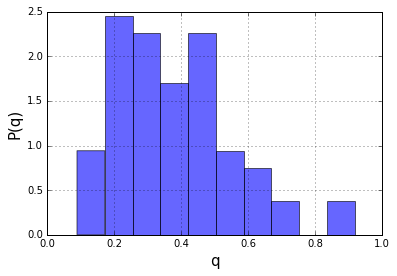

In [32]:
combined['q'] = combined.Mass / combined.M1
combined.drop_duplicates(subset=['Star'])['q'].hist(alpha=0.6, normed=True)
plt.xlabel('q', fontsize=15)
plt.ylabel('P(q)', fontsize=15)
#qplot = np.arange(0.05, 1, 0.01)
#gamma = 0.2
#plt.plot(qplot, (1-gamma)*qplot**(-gamma), 'r-', lw=3, alpha=0.6)
plt.savefig('Figures/MyMassRatios.pdf')

# Measure the companion RVs for each detection.

In [59]:
detections = pd.read_csv('/home/kgullikson/School/Research/BinaryInference/Companion_Data.csv', sep='|', index_col=0)
detections.rename(columns={'[Fe/H]': 'feh', 'addmode': 'best_addmode'}, inplace=True)
detections[['identifier', 'Instrument', 'parsed_date', 'Temperature', 'vsini_sec', 'feh']].head()

,identifier,Instrument,parsed_date,Temperature,vsini_sec,feh
10,HIP 2548,HET,2013-08-12,5600,30,-0.5
11,HIP 2548,IGRINS,2015-08-06,6000,30,0.0
17,HIP 3478,TS23,2014-01-12,5800,5,-0.5
30,HIP 5310,IGRINS,2014-10-14,3400,30,0.0
43,HR 545,IGRINS,2014-10-14,4500,5,-0.5


In [9]:
# Check if the filename actually exists. If not, there is a UT/civil date disagreement.
hdf_int = HDF5_Helpers.Full_CCF_Interface()

In [60]:
def check_date(date, possible_dates, fall2user=True):
    if date in possible_dates:
        return date
    elif len(possible_dates) == 1:
        return possible_dates[0]
    
    elif fall2user:
        print('\nDataFrame date is : {}\nPossible dates are'.format(date))
        for i, d in enumerate(possible_dates):
            print('[{}]: {}'.format(i+1, d))
        
        idx = int(raw_input('Enter the number of the correct date.')) - 1
        return possible_dates[idx]
    raise KeyError
    
def get_true_date(row):
    instrument = row.Instrument
    date = row.parsed_date
    star = row.identifier
    interface = hdf_int._interfaces[instrument]
    possible_dates = interface.list_dates(star)
    try:
        return check_date(date, possible_dates, fall2user=False)
    except KeyError:
        year, month, day = [int(s) for s in date.split('-')]
        t = datetime.datetime(year=year, month=month, day=day) + datetime.timedelta(1)
        new_date = '{}-{:02d}-{:02d}'.format(t.year, t.month, t.day)
        return check_date(new_date, possible_dates, fall2user=True)
        
detections['UT_date'] = detections.apply(get_true_date, axis=1)

In [63]:
detections[['identifier', 'Instrument', 'parsed_date', 'UT_date', 'Temperature', 'vsini_sec', 'feh', 'Velocity', 'best_addmode']].head()

,identifier,Instrument,parsed_date,UT_date,Temperature,vsini_sec,feh,Velocity,best_addmode
10,HIP 2548,HET,2013-08-12,2013-08-12,5600,30,-0.5,6.985,simple
11,HIP 2548,IGRINS,2015-08-06,2015-08-06,6000,30,0.0,2.853,simple
17,HIP 3478,TS23,2014-01-12,2014-01-12,5800,5,-0.5,-46.170,simple
30,HIP 5310,IGRINS,2014-10-14,2014-10-15,3400,30,0.0,4.825,simple
43,HR 545,IGRINS,2014-10-14,2014-10-15,4500,5,-0.5,-34.854,simple


In [50]:
home = os.environ['HOME']
instrument_dirs = dict(TS23='{}/School/Research/McDonaldData'.format(home),
                       CHIRON='{}/School/Research/CHIRON_data'.format(home),
                       HET='{}/School/Research/HET_data'.format(home),
                       IGRINS='{}/School/Research/IGRINS_data'.format(home))

oh_file = "{}/School/Research/IGRINS_data/plp/master_calib/ohlines.dat".format(home)
def add_oh_lines(oh_file, badregions=[], minstrength=1.0, tol=0.05):
    oh_data = pd.read_csv(oh_file, header=None, sep=" ", skipinitialspace=True, names=['wave', 'strength'])
    oh = oh_data[oh_data['strength'] > minstrength].copy()
    n = 1.0 + 2.735182e-4 + 131.4182 / oh['wave'] ** 2 + 2.76249e8 / oh['wave'] ** 4
    oh['wave'] = oh['wave'] / (n * 10.0)
    for wave in oh['wave'].values:
        badregions.append([wave - tol, wave + tol])
    return badregions
settings = dict(TS23=dict(badregions=[[567.5, 575.5],
                                      [588.5, 598.5],
                                      [627, 632],
                                      [647, 655],
                                      [686, 706],
                                      [716, 734],
                                      [759, 9e9]], 
                          interp_regions=[], 
                          trimsize=10),
               HET=dict(badregions = [[0, 450.],
                                      [567.5, 575.5],
                                      [588.5, 598.5],
                                      [627, 632],
                                      [647, 655],
                                      [686, 706],
                                      [716, 734],
                                      [759, 9e9]],
                        interp_regions = [],
                        trimsize = 10),
               CHIRON=dict(badregions = [[567.5, 575.5],
                                         [588.5, 598.5],
                                         [627, 632],
                                         [647, 655],
                                         [686, 706],
                                         [716, 734],
                                         [759, 9e9]],
                           interp_regions = [],
                           trimsize = 10),
               IGRINS=dict(badregions = [[0, 1510],
                                         [1740, 2090],  
                                          [2380, 2500]],
                           interp_regions=add_oh_lines(oh_file, badregions=[]),
                           trimsize=10
                            ))





In [90]:

def measure_rv(row):
    row_dict = row.to_dict()
    try:
        ds = hdf_int._interfaces[row['Instrument']].hdf5['{identifier}/{UT_date}/T{Temperature:.0f}_logg4.5_metal{feh:.1f}_addmode-{best_addmode}_vsini{vsini_sec:.0f}'.format(**row_dict)]
    except KeyError:
        ds = hdf_int._interfaces[row['Instrument']].hdf5['{identifier}/{UT_date}/T{Temperature:.0f}_logg4.5_metal{feh:.1f}_addmode-{best_addmode}_vsini{vsini_sec:.1f}'.format(**row_dict)]
    
    # 1. Read in the original file, find the number of pixels
    filename = os.path.join(instrument_dirs[row['Instrument']], ds.attrs['fname'])
    vsini_prim = prim_vsini = get_vsini([filename])[0]
    orders = Process_Data(filename, logspacing=True,
                          extensions=True, vsini=vsini_prim,
                          reject_outliers=True, **settings[row['Instrument']])
    Npix = sum([o.size() for o in orders])

    
    # 2. Read in the CCF data from the dataset. If the max is significantly different than vel_max, 
    #    check if it is close to vel_max + vbary. If so, add vbary to the velocity axis
    vel, corr = ds.value
    vel_offset = 0.0
    if abs(vel[np.argmax(corr)] - ds.attrs['vel_max']) > 0.5:
        if abs(vel[np.argmax(corr)] + ds.attrs['vbary'] - ds.attrs['vel_max']) < 0.5:
            vel_offset = ds.attrs['vbary']
        else:
            raise ValueError('Something is weird with the velocity for dataset {} (instrument {})'.format(ds.name, row['Instrument']))
    print('Velocity offset: {}'.format(vel_offset))
    
    # 3. Find the best rv with associated error using the maximum-likelihood-added CCF.
    #    May need to add a mechanism to give get_rv a region to search (or just don't give it the whole arrays...)
    rv_dict = defaultdict(list)
    for addmode in ['ml', 'dc', 'simple']:
        new_ds = hdf_int._interfaces[row['Instrument']].hdf5[ds.name.replace('addmode-'+row['best_addmode'], 'addmode-'+addmode)]
        vel, corr = new_ds.value
        print(vel)
        vel += vel_offset
        good = np.abs(vel - ds.attrs['vel_max']) < 25
        rv, rv_err, ccf = get_rv(vel[good], corr[good], Npix)
        rv_dict['addmode'].append(addmode)
        rv_dict['RV'].append(rv)
        rv_dict['RV_err'].append(rv_err)
        rv_dict['CCF'].append(ccf)
        rv_dict['vbary'].append(new_ds.attrs['vbary'])
    
    df = pd.DataFrame(data=rv_dict)
    for key in row.keys():
        df[key] = row[key]
    return df

#out = []
#for _, row in detections.iterrows():
#    out.append(measure_rv(row))
#rv_data = pd.concat(out, ignore_index=True)
#rv_data.head()

In [116]:
measure_rv(detections.loc[17])

/home/kgullikson/School/Research/McDonaldData/20140112/HIP_3478.fits 128.0
Removing order 54
Removing order 53
Removing order 52
Removing order 51
Removing order 50
Removing order 49
Removing order 48
Removing order 47
Removing order 46
Removing order 45
Removing order 44
Removing order 43
Removing order 41
Removing order 40
Removing order 39
Removing order 38
Removing order 35
Removing order 30
Removing order 28
Velocity offset: -23.16
[  975.22816298   972.81695988   970.40575679   967.99455369   965.5833506
   963.1721475    960.76094441   958.34974131   955.93853822   953.52733512
   951.11613203   948.70492893   946.29372584   943.88252274   941.47131965
   939.06011655   936.64891346   934.23771036   931.82650727   929.41530417
   927.00410108   924.59289798   922.18169489   919.77049179   917.3592887
   914.9480856    912.53688251   910.12567941   907.71447632   905.30327322
   902.89207013   900.48086703   898.06966393   895.65846084   893.24725774
   890.83605465   888.4248515

,CCF,RV,RV_err,addmode,vbary,identifier,SpT,configuration,Instrument,Date,...,Rank,Keck,VLT,Gemini,Imaging_Detecton,best_addmode,parsed_date,Tmeas,Tmeas_err,UT_date
0,0.0448903318329,-33.801853,NaN,ml,-23.16,HIP 3478,B5V,B5V,TS23,20140112,...,7,n,n,n,NaN,simple,2014-01-12,5799.802745,215.990025,2014-01-12
1,0.0447985477846,-33.788665,NaN,dc,-23.16,HIP 3478,B5V,B5V,TS23,20140112,...,7,n,n,n,NaN,simple,2014-01-12,5799.802745,215.990025,2014-01-12
2,-0.033293605521,-23.196673,1.837202,simple,-23.16,HIP 3478,B5V,B5V,TS23,20140112,...,7,n,n,n,NaN,simple,2014-01-12,5799.802745,215.990025,2014-01-12


In [157]:
rv_data.to_csv('Companion_RV_data.csv', sep='|', encoding='utf-8')

(-46.169918417978451, -23.16, -23.009918417978454)
23.16


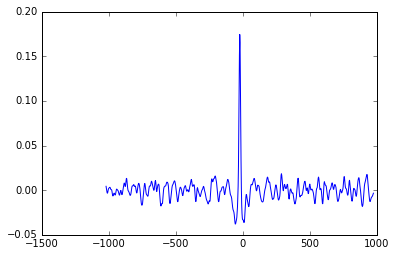

In [80]:
def plot_ccf(**row):
    ds = hdf_int._interfaces[row['Instrument']].hdf5['{identifier}/{UT_date}/T{Temperature:.0f}_logg4.5_metal{feh:.1f}_addmode-{addmode}_vsini{vsini_sec:.0f}'.format(**row)]
    vel, corr = ds.value
    plt.plot(vel, corr)
    print(ds.attrs['vel_max'], ds.attrs['vbary'], vel[np.argmax(corr)])
    print(abs(vel[np.argmax(corr)] - ds.attrs['vel_max']))

pars = dict(Instrument='TS23',
            identifier='HIP 3478',
            UT_date='2014-01-12',
            Temperature=5800,
            logg=4.5,
            feh=-0.5,
            addmode='simple',
            vsini_sec=5)

%matplotlib inline
plot_ccf(**pars)

# Remake CCFs
What is the velocity when I do the barycentric correction correctly?

In [92]:
detections[['identifier', 'Instrument', 'parsed_date', 'UT_date', 'Temperature', 'vsini_sec', 'feh', 'Velocity', 'best_addmode']].head()

,identifier,Instrument,parsed_date,UT_date,Temperature,vsini_sec,feh,Velocity,best_addmode
10,HIP 2548,HET,2013-08-12,2013-08-12,5600,30,-0.5,6.985,simple
11,HIP 2548,IGRINS,2015-08-06,2015-08-06,6000,30,0.0,2.853,simple
17,HIP 3478,TS23,2014-01-12,2014-01-12,5800,5,-0.5,-46.170,simple
30,HIP 5310,IGRINS,2014-10-14,2014-10-15,3400,30,0.0,4.825,simple
43,HR 545,IGRINS,2014-10-14,2014-10-15,4500,5,-0.5,-34.854,simple


In [103]:
import StellarModel
from astropy import units as u
from astropy.io import fits
import Broaden
import GenericSearch
import StarData
import Correlate
import SpectralTypeRelations

hdf5_file = '/media/ExtraSpace/PhoenixGrid/TS23_Grid.hdf5'
Tvalues = [5800]
metal_values = [0.0]
logg_values = [4.5]
vsini_values = [5]

model_list = StellarModel.GetModelList(type='hdf5',
                                       hdf5_file=hdf5_file,
                                       temperature=Tvalues,
                                       metal=metal_values,
                                       logg=logg_values)
modeldict, processed = StellarModel.MakeModelDicts(model_list, type='hdf5', hdf5_file=hdf5_file,
                                                   vsini_values=vsini_values, vac2air=True, logspace=True)
model = modeldict[5800][4.5][0.0][0.0][5]
l_idx = 0
r_idx = model.size()
model = Broaden.RotBroad(model[l_idx:r_idx], 5.0 * u.km.to(u.cm), linear=True)

In [107]:

MS = SpectralTypeRelations.MainSequence()

fname = '/home/kgullikson/School/Research/McDonaldData/20140112/HIP_3478.fits'
header = fits.getheader(fname)
vbary = GenericSearch.HelCorr_IRAF(header, observatory='mcdonald')
vsini_prim = StarData.get_vsini([fname])[0]
spt = StarData.GetData(header['OBJECT']).spectype
prim_teff = MS.Interpolate('Temperature', spt)
orders = GenericSearch.Process_Data(fname, vsini=vsini_prim, reject_outliers=True, 
                                    logspacing=True, extensions=True, **settings['TS23'])


INFO:root:Getting stellar data for HIP 3478


/home/kgullikson/School/Research/McDonaldData/20140112/HIP_3478.fits 128.0
Removing order 54
Removing order 53
Removing order 52
Removing order 51
Removing order 50
Removing order 49
Removing order 48
Removing order 47
Removing order 46
Removing order 45
Removing order 44
Removing order 43
Removing order 41
Removing order 40
Removing order 39
Removing order 38
Removing order 35
Removing order 30
Removing order 28




-23.009918418


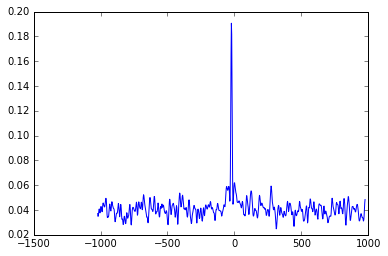

In [121]:


model_orders = GenericSearch.process_model(model.copy(), orders, vsini_primary=vsini_prim, maxvel=1000.0,
                                           debug=False, oversample=1, logspace=False)

corr = Correlate.Correlate(orders, model_orders, addmode='all', outputdir='./',
                           get_weights=False, prim_teff=prim_teff,
                           orderweights=None, debug=False)
corr.x += vbary
ccf = corr['ml']
plt.plot(ccf.x, ccf.y)
print(ccf.x[np.argmax(ccf.y)])

# Just remake all of the detection CCFs

In [131]:
detections.Instrument.unique()

array(['HET', 'IGRINS', 'TS23', 'CHIRON'], dtype=object)

In [154]:
PhoenixLibrary = dict(HET='/media/ExtraSpace/PhoenixGrid/HRS_Grid.hdf5',
                      TS23='/media/ExtraSpace/PhoenixGrid/TS23_Grid.hdf5',
                      CHIRON='/media/ExtraSpace/PhoenixGrid/CHIRON_Grid.hdf5',
                      IGRINS='/media/ExtraSpace/PhoenixGrid/IGRINS_Grid.hdf5')
def remeasure_rv(row):
    # 1. Read in the HDF5 dataset
    row_dict = row.to_dict()
    try:
        ds = hdf_int._interfaces[row['Instrument']].hdf5['{identifier}/{UT_date}/T{Temperature:.0f}_logg4.5_metal{feh:.1f}_addmode-{best_addmode}_vsini{vsini_sec:.0f}'.format(**row_dict)]
    except KeyError:
        ds = hdf_int._interfaces[row['Instrument']].hdf5['{identifier}/{UT_date}/T{Temperature:.0f}_logg4.5_metal{feh:.1f}_addmode-{best_addmode}_vsini{vsini_sec:.1f}'.format(**row_dict)]

    # 2. Get the appropriate model
    hdf5_file = '/media/ExtraSpace/PhoenixGrid/TS23_Grid.hdf5'
    Tvalues = np.atleast_1d(row['Temperature'])
    metal_values = np.atleast_1d(row['feh'])
    logg_values = np.atleast_1d(4.5)
    vsini_values = np.atleast_1d(row['vsini_sec'])
    instrument = row['Instrument']
    hdf5_file = PhoenixLibrary[instrument]
    print(hdf5_file)

    model_list = StellarModel.GetModelList(type='hdf5',
                                           hdf5_file=hdf5_file,
                                           temperature=Tvalues,
                                           metal=metal_values,
                                           logg=logg_values)
    modeldict, processed = StellarModel.MakeModelDicts(model_list, type='hdf5', hdf5_file=hdf5_file,
                                                       vsini_values=vsini_values, vac2air=True, logspace=True)
    model = modeldict[Tvalues[0]][logg_values[0]][metal_values[0]][0.0][vsini_values[0]]
    l_idx = 0
    r_idx = model.size()
    model = Broaden.RotBroad(model[l_idx:r_idx], vsini_values[0] * u.km.to(u.cm), linear=True)
    
    # 3: Read in and process the original datafile
    fname = os.path.join(instrument_dirs[instrument], ds.attrs['fname'])
    header = fits.getheader(fname)
    vbary = GenericSearch.HelCorr_IRAF(header, observatory='mcdonald')
    vsini_prim = StarData.get_vsini([fname])[0]
    spt = StarData.GetData(header['OBJECT']).spectype
    prim_teff = MS.Interpolate('Temperature', spt)
    orders = GenericSearch.Process_Data(fname, vsini=vsini_prim, reject_outliers=True, 
                                        logspacing=True, extensions=True, **settings[instrument])
    Npix = sum([o.size() for o in orders])
    
    # 4. Make the ccf
    model_orders = GenericSearch.process_model(model.copy(), orders, vsini_primary=vsini_prim, maxvel=1000.0,
                                           debug=False, oversample=1, logspace=False)
    corr = Correlate.Correlate(orders, model_orders, addmode='all', outputdir='./',
                               get_weights=False, prim_teff=prim_teff,
                               orderweights=None, debug=False)
    corr.x += vbary

    # 5. Find the maximum velocity for each ccf
    rv_dict = defaultdict(list)
    for addmode in ['ml', 'dc', 'simple']:
        ccf = corr[addmode]
        good = np.abs(ccf.x - ds.attrs['vel_max']) < 25
        #plt.plot(ccf.x[good], ccf.y[good], label=addmode)
        plt.plot(ccf.x, ccf.y, label=addmode)
        rv, rv_err, ccf = get_rv(ccf.x[good], ccf.y[good], Npix)
        rv_dict['addmode'].append(addmode)
        rv_dict['RV'].append(rv)
        rv_dict['RV_err'].append(rv_err)
        rv_dict['CCF'].append(ccf)
        rv_dict['vbary'].append(vbary)
    plt.legend(loc='best', fancybox=True)
    
    df = pd.DataFrame(data=rv_dict)
    for key in row.keys():
        df[key] = row[key]
    return df

out = []
for _, row in detections.iterrows():
    out.append(remeasure_rv(row))
rv_data = pd.concat(out, ignore_index=True)
#rv_data.head()

/media/ExtraSpace/PhoenixGrid/HRS_Grid.hdf5
/home/kgullikson/School/Research/HET_data/20130812/HIP_2548-0.fits

INFO:root:Getting stellar data for HIP 2548


 144.0
Removing order 62
Removing order 58
Removing order 57
Removing order 55
Removing order 54


KeyboardInterrupt: 

In [156]:
rv_data[['RV', 'RV_err', 'addmode', 'CCF', 'identifier', 'Instrument', 'Date']]

,RV,RV_err,addmode,CCF,identifier,Instrument,Date
0,7.242255,0.197262,ml,0.355765992245,HIP 2548,HET,20130812
1,7.303496,0.207293,dc,0.348065823561,HIP 2548,HET,20130812
2,7.366654,0.258603,simple,0.29957629237,HIP 2548,HET,20130812
3,-5.777667,0.974358,ml,0.120380960034,HIP 2548,IGRINS,20150806
4,-5.844623,0.985428,dc,0.119809777985,HIP 2548,IGRINS,20150806
5,2.809590,1.228435,simple,0.088244160592,HIP 2548,IGRINS,20150806
6,-22.674315,0.096730,ml,0.191448046084,HIP 3478,TS23,20140112
7,-22.669062,0.098004,dc,0.190161391951,HIP 3478,TS23,20140112
8,-22.635857,0.105762,simple,0.174839697941,HIP 3478,TS23,20140112
9,7.825231,0.839349,ml,0.0954563230645,HIP 5310,IGRINS,20141014


In [184]:
detections.loc[detections.identifier == 'HIP 109521']

,identifier,SpT,configuration,Instrument,Date,Temperature,Velocity,vsini_sec,feh,significance,...,Rank,Keck,VLT,Gemini,Imaging_Detecton,best_addmode,parsed_date,Tmeas,Tmeas_err,UT_date
514,HIP 109521,A5V,"((A5V + ?; ?) + 9.5K0; 73.7"")",IGRINS,20141014,4600,-5.091,10,0,38.098968,...,1,n,n,Y,"Observed with sphere, still under proprietary ...",simple,2014-10-14,4599.912027,215.697810,2014-10-15
515,HIP 109521,A5V,"((A5V + ?; ?) + 9.5K0; 73.7"")",TS23,20131021,4600,-11.703,10,0,31.926790,...,1,n,n,Y,NaN,simple,2013-10-21,4600.232905,215.768614,2013-10-21
516,HIP 109521,A5V,"((A5V + ?; ?) + 9.5K0; 73.7"")",TS23,20141101,4600,-12.848,10,0,26.489402,...,1,n,n,Y,NaN,simple,2014-11-01,4599.985533,215.729578,2014-11-01


/media/ExtraSpace/PhoenixGrid/TS23_Grid.hdf5
/home/kgullikson/School/Research/McDonaldData/20131021/HIP_109521.fits

INFO:root:Getting stellar data for HIP 109521


 115.2
Removing order 54
Removing order 53
Removing order 52
Removing order 51
Removing order 50
Removing order 49
Removing order 48
Removing order 47
Removing order 46
Removing order 45
Removing order 44
Removing order 43
Removing order 41
Removing order 40
Removing order 39
Removing order 38
Removing order 35
Removing order 30
Removing order 28




,CCF,RV,RV_err,addmode,vbary,identifier,SpT,configuration,Instrument,Date,...,Rank,Keck,VLT,Gemini,Imaging_Detecton,best_addmode,parsed_date,Tmeas,Tmeas_err,UT_date
0,0.277080700241,-3.852898,0.102816,ml,-6.86,HIP 109521,A5V,"((A5V + ?; ?) + 9.5K0; 73.7"")",TS23,20131021,...,1,n,n,Y,NaN,simple,2013-10-21,4600.232905,215.768614,2013-10-21
1,0.27103723029,-3.865390,0.107619,dc,-6.86,HIP 109521,A5V,"((A5V + ?; ?) + 9.5K0; 73.7"")",TS23,20131021,...,1,n,n,Y,NaN,simple,2013-10-21,4600.232905,215.768614,2013-10-21
2,0.22484346256,-4.058188,0.130374,simple,-6.86,HIP 109521,A5V,"((A5V + ?; ?) + 9.5K0; 73.7"")",TS23,20131021,...,1,n,n,Y,NaN,simple,2013-10-21,4600.232905,215.768614,2013-10-21


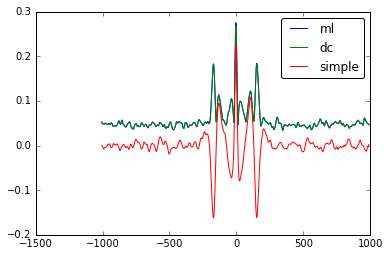

In [185]:
reload(Correlate)
get_rv = Correlate.get_rv
remeasure_rv(detections.loc[515])